<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\W'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipython-input-2400308837.py:27: SyntaxWarning: invalid escape sequence '\d'
  data['reviews'] = data['reviews'].str.replace('\d+', ' ', regex=True)
/tmp/ipython-input-2400308837.py:28: SyntaxWarning: invalid escape sequence '\W'
  data['reviews'] = data['reviews'].str.replace('\W', ' ', regex=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


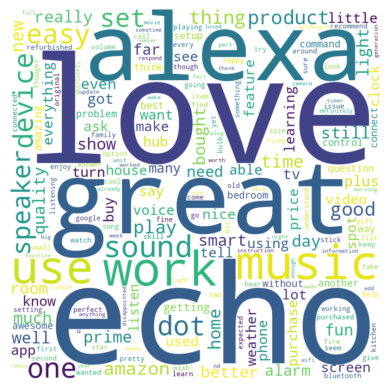

Number of samples for training [news]:(2520, 165)
Number of sample for training [Labels]:(2520, 2)
Number of samples for testing [news]:(630, 165)
Number of sample for testing [Labels]:(630, 2)
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


KeyboardInterrupt: 

In [6]:
import numpy as np
from os.path import join
import pandas as pd
import nltk
nltk.download('stopwords')
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import wordcloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

data = pd.read_csv('customer_reviewers.tsv', sep='\t')

data.columns = ["rating", "date", "variation", "reviews", "feedback"]
data.head(10)

# Remove stop words using nltk
data['reviews'] = data['reviews'].str.lower()
data['reviews'] = data['reviews'].str.replace('\d+', ' ', regex=True)
data['reviews'] = data['reviews'].str.replace('\W', ' ', regex=True)

stopwords_list = set(stopwords.words('english'))
data['reviews'] = data['reviews'].fillna('').apply(lambda word: ' '.join(word for word in word.split()
if word not in stopwords_list))

data.head(10)

# Gather common words and display a word cloud
common_words=' '

for i in data.reviews:
  i = str(i)
  word = i.split()
  common_words += " ".join(word)+" "

newCloud = wordcloud.WordCloud(width = 800, height = 800, background_color="white", min_font_size = 10, collocations=False).generate(common_words)

# Display the word cloud
plt.imshow(newCloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Embed using label encoder
labelEncoder = LabelEncoder()

data['rating'] = labelEncoder.fit_transform(data['rating'])

data.head(10)

# Tokenizer
tokenizer = Tokenizer(num_words=500, split=' ');
tokenizer.fit_on_texts(data['reviews'].values);
X = tokenizer.texts_to_sequences(data['reviews'].values);
X[0:5];
X = pad_sequences(X);

data.head(10)

INPUT_LENGTH = X.shape[1] if 'X' in locals() else 50
VOCAB_SIZE = tokenizer.num_words if 'tokenizer' in locals() else 500

model = Sequential()

EMBEDDING_DIM = 120
model.add(Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length=INPUT_LENGTH))

model.add(SpatialDropout1D(0.4))

LSTM_UNITS = 176
model.add(LSTM(units=LSTM_UNITS,
               dropout=0.2,
               recurrent_dropout=0.2))

data['sentiment_target'] = data['rating'].apply(lambda x: 1 if x >= 3 else 0)

Y_binary = data['sentiment_target'].values

NUM_CLASSES = 2
Y_one_hot_corrected = to_categorical(Y_binary, num_classes=NUM_CLASSES)

TEST_SIZE = 0.2
RANDOM_STATE = 42

# Train our model
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_one_hot_corrected,test_size=0.20)
print("Number of samples for training [news]:{}\nNumber of sample for training [Labels]:{}".format(X_train.shape,Y_train.shape))
print("Number of samples for testing [news]:{}\nNumber of sample for testing [Labels]:{}".format(X_test.shape,Y_test.shape))

model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose='auto')

# Evaluate the Model
Y_pred_proba = model.predict(X_test)
Y_pred = np.argmax(Y_pred_proba, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

# --- Performed Evaluation ---
target_names = ['Negative/Neutral (0)', 'Positive (1)']
report = classification_report(Y_test_labels, Y_pred, target_names=target_names)

print("--- CLASSIFICATION REPORT (Performed Evaluation) ---")
print(report)

print("--- Model Evaluation Preparation Complete ---")

Client Program

In [5]:

# Requirement 2: Clean the review from stop words (implemented function)
def clean_review(review, stopwords_list):
    """Cleans a single review string from numbers, punctuation, and stop words."""
    # Convert to lowercase
    review = review.lower()
    # Remove numbers and punctuation
    review = re.sub(r'\d+', ' ', review)
    review = re.sub(r'\W', ' ', review)
    # Remove stopwords
    return ' '.join(word for word in review.split() if word not in stopwords_list)

# Requirement 3: Turn the review's words into a vector
def vectorize_review(review, tokenizer, input_length):
    """Converts a cleaned review string to a padded sequence."""
    # Tokenize (convert to sequence of integers)
    seq = tokenizer.texts_to_sequences([review])
    # Pad the sequence to the fixed input length
    return pad_sequences(seq, maxlen=input_length)

# Requirement 4: Used the trained model to predict the client's review sentiment and print
def predict_sentiment(review_text, model, tokenizer, stopwords_list, input_length):
    """Runs the full prediction pipeline for a new review."""

    # Clean the review
    cleaned_review = clean_review(review_text, stopwords_list)

    # Vectorize the review
    X_review = vectorize_review(cleaned_review, tokenizer, input_length)

    # Predict probabilities (verbose=0 suppresses Keras output)
    prediction_proba = model.predict(X_review, verbose=0)[0]

    # Get the final sentiment label (0 or 1) using argmax
    sentiment_index = np.argmax(prediction_proba)

    # Map index to sentiment string
    sentiment_map = {0: "Negative/Neutral", 1: "Positive"}
    predicted_sentiment = sentiment_map[sentiment_index]

    print("-" * 60)
    print(f"Client Review: '{review_text}'")
    print("-" * 60)
    print(f"Cleaned Review (vectorized): '{cleaned_review}'")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Confidence: Positive {prediction_proba[1]:.2f}, Negative/Neutral {prediction_proba[0]:.2f}")
    print("-" * 60)
    return predicted_sentiment

print("Please input a review: ")
newReview = input()
predict_sentiment(newReview, model, tokenizer, stopwords_list, INPUT_LENGTH)

Please input a review: 
I believe this product is amazing! I think it is a wonderful piece of hardware and I hope that I can recommened it to everyone who uses it. Please buy this product! It is awesome!
------------------------------------------------------------
Client Review: 'I believe this product is amazing! I think it is a wonderful piece of hardware and I hope that I can recommened it to everyone who uses it. Please buy this product! It is awesome!'
------------------------------------------------------------
Cleaned Review (vectorized): 'believe product amazing think wonderful piece hardware hope recommened everyone uses please buy product awesome'
Predicted Sentiment: Positive
Confidence: Positive 1.00, Negative/Neutral 0.00
------------------------------------------------------------


'Positive'